In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LogNorm
import numpy as np
from py_unsio import *
import pymc
import wkbl
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import warnings
import emcee
import scipy
warnings.filterwarnings('ignore')

In [3]:
print emcee.__version__

2.2.1


In [4]:
path = "/data/OWN/DMO/mochima2/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myDMO = wkbl.Galaxy_Hound(path)
print "centering"
zoom_reg = np.where(myDMO.dm.mass == myDMO.dm.mass.min())
nucenter = nbe.real_center(myDMO.dm.pos3d[zoom_reg], myDMO.dm.mass[zoom_reg])
myDMO.center_shift(nucenter)
myDMO.r_virial(600)
print "done r200 = {0}".format(myDMO.r200)
myDMO.redefine(2.5)

ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32), myDMO.dm.mass)


Pcrit = myDMO.dm._p.rho_crit
Mdm = myDMO.dm.mass.min()
myradiuses = myDMO.dm.r[np.argsort(myDMO.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03
hsml=  R_P03
# R array logarithmic Bining
r_p = np.logspace(np.log10(hsml),np.log10(2.5*myDMO.r200),100)
# histogram of dm particles per logarithmic bin
n_dm,r = np.histogram(myDMO.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
r_size = r_p[1:]-r_p[:-1]
# density per shell
profileDMO = n_dm*myDMO.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r


Delta_rho = (myDMO.dm.mass.min() /vol) + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho2 = np.sqrt((myDMO.dm.mass.min()/np.sqrt(n_dm) /vol)**2 + (4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)**2)
Delta_rho3 =(4*np.pi*(r**2)* (n_dm*myDMO.dm.mass.min()) * r_size / vol**2)
Delta_rho4 =(myDMO.dm.mass.min() /vol)

# extra estatistics from Cfalcon density
mean = np.array([])
std = np.array([])
n=np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myDMO.dm.r > r_p[i])&(myDMO.dm.r < r_p[i+1])&(myDMO.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(myDMO.dm.rho[shell]))
    std = np.append(std,np.std(myDMO.dm.rho[shell]))
    
    
    

###########

loading Dark matter..
centering
done r200 = 229.1015625
1.96601130417


In [5]:
def chi2_rho(p):
    po,r_s,al,be,ga = p[0],p[1],p[2],p[3],p[4]
    rho_obs = profileDMO
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in r])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ np.log10(std)
    c = c**2
    return np.sum(c)

In [6]:
def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

In [150]:

# Now, let's setup some parameters that define the MCMC
ndim = 6
nwalkers = 500

# Initialize the chain
# Choice 1: chain uniformly distributed in the range of the parameters
po_min, po_max = 5,11.
r_s_min, r_s_max = 0.,20
al_min, al_max = .5,1.5
be_min, be_max = 2.5,3.5
ga_min, ga_max = .5,1.2
pos_min = np.array([po_min,   r_s_min, al_min, be_min, ga_min,-10 ])
pos_max = np.array([po_max,   r_s_max, al_max, be_max, ga_max, 2])
psize = pos_max - pos_min
pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

# Visualize the initialization

In [151]:
z=np.array([list(i) for i in pos] )
np.mean(z[:,1])

10.114840444269989

In [152]:
np.mean(z[:,3])

3.0047287264702303

In [153]:
# Define the posterior PDF
# Reminder: post_pdf(theta, data) = likelihood(data, theta) * prior_pdf(theta)
# We take the logarithm since emcee needs it.

# As prior, we assume an 'uniform' prior (i.e. constant prob. density)
def lnprior(theta):
    po,r_s,al,be,ga = theta
    if  po_min < po < po_max and\
        r_s_min < r_s < r_s_max and\
        al_min < al < al_max and\
        be_min < be < be_max and\
        ga_min < ga < ga_max:
        return 0.0
    else:
        return -np.inf
    
    
def log_prior(theta):
    po,r_s,al,be,ga, log_f = theta
    if po_min < po < po_max and\
         r_s_min < r_s < r_s_max and\
           al_min < al < al_max and\
             be_min < be < be_max and\
                ga_min < ga < ga_max and\
                  -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

"""
# As likelihood, we assume the chi-square. Note: we do not even need to normalize it.
def lnlike(theta, x, y, yerr):
    po,r_s,al,be,ga = theta
    rho_obs = y
    rho_the = np.array([abg_profile(i,po,r_s,al,be,ga) for i in x])
    c = (np.log10(rho_the) - np.log10(rho_obs))/ np.log10(std)
    c = c**2
    return np.sum(c)
"""
def log_likelihood(theta, x, y, yerr):
    po,r_s,al,be,ga, log_f = theta
    model = abg_profile(x,po,r_s,al,be,ga)
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))
"""
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ln = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp) or not np.isfinite(ln):
        return -np.inf
    else:
        return ln
""" 
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [154]:

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(r, profileDMO, std))
sampler.run_mcmc(pos, 5000);

<IPython.core.display.Javascript object>


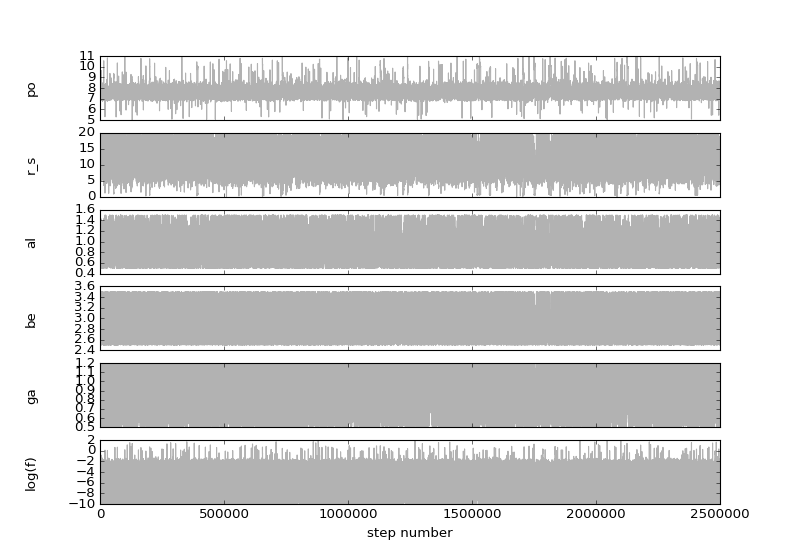

In [155]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.flatchain
labels = ["po", "r_s","al","be","ga", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [156]:
flat_samples = sampler.flatchain

In [157]:
inds = np.random.randint(len(flat_samples), size=100)

In [158]:


from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [159]:
np.percentile(flat_samples[:, 0], [16, 50, 84])

array([ 7.23197466,  7.61014577,  8.10622694])

In [160]:
print "rho_0",flat_samples[:, 0].mean(),flat_samples[:, 0].std()
print "r_s",flat_samples[:, 1].mean(),flat_samples[:, 1].std()
print "alpha",flat_samples[:, 2].mean(),flat_samples[:, 2].std()
print "beta",flat_samples[:, 3].mean(),flat_samples[:, 3].std()
print "gamma",flat_samples[:, 4].mean(),flat_samples[:, 4].std()

rho_0 7.70697130412 0.562898223879
r_s 11.1845574985 4.61356801864
alpha 0.852470249696 0.251933599227
beta 2.95640452971 0.274649682583
gamma 0.916510417264 0.187885151199


<IPython.core.display.Javascript object>


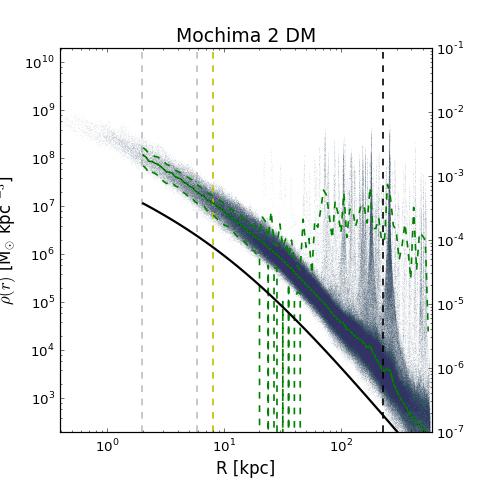

7.70697130412


In [161]:
fig, ax = plt.subplots(figsize=[6,6])
ax2 = ax.twinx()
ax.set_xlim([0.2*hsml,600])
ax.set_ylim([2e2,2e10])
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')

ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_title("Mochima 2 DM",fontsize=17)
#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myDMO.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profileDMO+std
mean_minu = profileDMO-std
"""
ax.plot(r,profileDMO+Delta_rho4,color='g',linestyle='--', linewidth=1.5)
ax.plot(r,profileDMO-Delta_rho4,color='g',linestyle='--', linewidth=1.5)
ax.plot(r,profileDMO+std,color='m',linestyle='--', linewidth=1.5)
ax.plot(r,profileDMO-std,color='m',linestyle='--', linewidth=1.5)
"""
#  plot things
#ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.02,lw=0,alpha=0.6,c='#FF9100')
"""
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')
ax.errorbar(r,profileDMO,xerr=bin_size,yerr=std)
"""
ax.scatter(myDMO.dm.r,myDMO.dm.rho,s=0.1,lw=0,alpha=0.2,c='#6699CC')

#plot means
#ax.plot(r_p[:-1],mean,lw=1.5)
ax.plot(r,profileDMO,lw=1.5,color='g',ls='-',marker='o',markersize=0.2)
ax.plot(r,profileDMO+std,lw=1.5,color='g',ls='--')
ax.plot(r,profileDMO-std,lw=1.5,color='g',ls='--')

po,r_s,al,be,ga = flat_samples[:, 0].mean(),flat_samples[:, 1].mean(),flat_samples[:, 2].mean(),flat_samples[:, 3].mean(),flat_samples[:, 4].mean()
#po,r_s,al,be,ga = params2[0],params2[1],params2[2],params2[3],params2[4]
ax.plot(r,(abg_profile(r,6.6,r_s,al,be,ga)),
        "k",lw=2)
print po
#ax.plot(r,(abg_profile(r,m_bin.values['po'] ,m_bin.values['r_s'],m_bin.values['al'],m_bin.values['be'],m_bin.values['ga'])),
#        color="#660000",lw=2)

#ax.plot(r,(abg_profile(r,m_sur.values['po'] ,m_sur.values['r_s'],m_sur.values['al'],m_sur.values['be'],m_sur.values['ga'])),
#        color="#3399CC",lw=2)
#ax2.plot(r,n_dm*myDMO.dm.mass.min(),'b-o',markersize=3)
#ax2.plot(r,mass_bin,"#660000",markersize=3)
#ax2.plot(r,mass_rho,'k',markersize=3)


In [91]:
xcghsdfh

NameError: name 'xcghsdfh' is not defined

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                lnprob, args=(r, profileDMO, std))

In [ ]:

# burnin phase
pos, prob, state  = sampler.run_mcmc(pos, 300)




In [ ]:
z=np.array([list(i) for i in pos] )
np.mean(z[:,1])

In [ ]:
np.mean(z[:,4])

In [ ]:
# perform MCMC
pos, prob, state  = sampler.run_mcmc(pos, 700)



In [ ]:
z=np.array([list(i) for i in pos] )
np.mean(z[:,1])

In [ ]:


samples = sampler.flatchain
samples.shape

In [ ]:
samples[-1]

In [ ]:
samples = sampler.flatchain
sam=samples#[-400:]
"""
chi2 = np.array([lnlike(i,r,profileDMO,std) for i in sam])
params = sam[np.where(chi2==np.min(chi2))][0]
print params
print lnlike(params,r,profileDMO,std)
"""
chi2_2 = np.array([lnprob(i,r,profileDMO,std) for i in sam])
sam = sam[np.isfinite(chi2_2)]
chi2_2 = chi2_2[np.isfinite(chi2_2)]

params2 = sam[np.where(chi2_2==np.min(chi2_2))][0]
print params2
print lnlike(params2,r,profileDMO,std),lnprob(params2,r,profileDMO,std)